# Preamble

In [1]:
class Odesol:
    def __init__(self,variables,ivar,eqs,params,ics=[0,0,0],tf=10,solve=False):
        self.vars = variables
        self.ivar = ivar
        self.eqs = eqs
        self.params = params  # Dictionary
        self.sol = []
        self.xt = []
        self.xy = []
        self.yt = []
        self.yx = []
        self.step = 0.1
        self.tf = tf
        self.ics = ics
        self.eqs_no_par = [eq.subs(self.params) for eq in self.eqs]
        if solve: self.solve(self.tf)

    def set_ics(self, new_ics):
        self.ics = new_ics
    def set_params(self,params):
        self.params = params
        self.eqs_no_par = [eq.subs(self.params) for eq in self.eqs]
    def set_step(self,step):
        self.step = step

    def solve(self, tf = None, update=True, step=None):
        if not tf == None : self.tf = tf
        if not step == None : self.step = step
        self.sol = desolve_system_rk4(self.eqs_no_par,self.vars,ics=self.ics, ivar=self.ivar, end_points=self.tf, step=self.step)
        if update: self.update_lists()
    
    def update_xt(self):
        self.xt =  [(i,j) for i,j,k in self.sol]
    def update_yt(self):
        self.yt =  [(i,k) for i,j,k in self.sol]
    def update_xy(self):
        self.xy =  [(j,k) for i,j,k in self.sol]
    def update_yx(self):
        self.yx =  [(k,j) for i,j,k in self.sol]
    
    def update_lists(self):
        self.update_xt()
        self.update_yt()
        self.update_xy()
        self.update_yx()
    
    def xtime_range(self,t1,t2):
        return [(i,j) for i,j in self.xt if t1<=i<=t2]
    def ytime_range(self,t1,t2):
        return [(i,j) for i,j in self.yt if t1<=i<=t2]
    def xytime_range(self,t1,t2):
        return[triplet for triplet in self.sol if t1<=triplet[0]<=t2]

    def plot_xt(self,t1=None,t2=None,color='blue',legend_label=None):
        if t1 == None and t2 == None: 
            return list_plot(self.xt, plotjoined=True, color=color, legend_label=legend_label)
        else:
            if t1 == None: t1 = self.ics[0]
            if t2 == None: t2 = self.tf
            return list_plot(self.xtime_range(t1,t2), plotjoined=True, color=color, legend_label=legend_label)

    def plot_yt(self,t1=None,t2=None,color='blue',legend_label=None):
        if t1 == None and t2 == None: 
            return list_plot(self.yt, plotjoined=True, color=color, legend_label=legend_label)
        else:
            if t1 == None: t1 = self.ics[0]
            if t2 == None: t2 = self.tf
            return list_plot(self.ytime_range(t1,t2), plotjoined=True, color=color, legend_label=legend_label)

    def plot_xy(self,color='blue',legend_label=None):
        return list_plot(self.xy, plotjoined=True, color=color, legend_label=legend_label)
    def plot_yx(self,color='blue',legend_label=None):
        return list_plot(self.yx, plotjoined=True, color=color, legend_label=legend_label)
    
    def xt_spline(self,t1=None,t2=None):
        if t1 == None and t2 == None: 
            return spline(self.xt)
        else:
            if t1 == None: t1 = self.ics[0]
            if t2 == None: t2 = self.tf
            return spline(self.xtime_range(t1,t2))
    
    def yt_spline(self,t1=None,t2=None):
        if t1 == None and t2 == None: 
            return spline(self.yt)
        else:
            if t1 == None: t1 = self.ics[0]
            if t2 == None: t2 = self.tf
            return spline(self.ytime_range(t1,t2))


In [2]:
def findT(odesol,t1,t2,digits=10,coord=2):
    # coord: 1 = x, 2 = y
    ode = copy(odesol)
    ode.solve(t2,update=False)
    step = ode.step
    values = ode.xytime_range(t1,t2)

    if len(values) <= 1:
        step = (t2-t1)/10.
        ode.set_ics(ode.xytime_range(0,t1)[-1])
        ode.solve(t2,update=False,step=step)
        digits -= 1
        values = ode.xytime_range(t1,t2)

    for i in range(len(values)):
        if not sign(values[i][coord]) == sign(values[i+1][coord]):
            new_values = [values[i],values[i+1]]
            break
    # new_ics = new_values[0]
    for i in range(digits):
        step /= 10
        ode.set_ics(new_values[0])
        ode.solve(new_values[1][0],update=False,step=step)
        for i in range(len(ode.sol)):
            if not sign(ode.sol[i][coord]) == sign(ode.sol[i+1][coord]):
                new_values = [ode.sol[i],ode.sol[i+1]]
                break
    return new_values

In [3]:
def retorn(odesol, rho, t1, t2, coord=2, time=False):
    ode = copy(odesol)
    if coord == 2:
        ode.set_ics([0,rho,0])
    else:
        ode.set_ics([0,0,rho])
    if coord == 2:
        if time:
            result = findT(ode,t1,t2,coord=coord)[1]
            return [result[1],result[0]]
        else:
            return findT(ode,t1,t2,coord=coord)[1][1]
    else:
        if time:
            result = findT(ode,t1,t2,coord=coord)[1]
            return [result[2],result[0]]
        else:
            return findT(ode,t1,t2,coord=coord)[1][2]

def desplacament(odesol, rho, t1, t2):
    return (rho, retorn(odesol, rho, t1, t2)- rho)

In [187]:
def find_T_p(odesol, rho1, rho2, t1, t2):
    ode = copy(odesol)
    rho_step = (rho2-rho1)/10.
    # Calculem 10 punts de la funció desplaçament entre rho1 i rho2
    desp = [desplacament(ode,rho1+i*rho_step, t1, t2) for i in range(0,10)]
    desp_spline = spline(desp)
    rho_candidate = find_root(desp_spline, rho1, rho2)
    ode.set_ics([0,RR(rho_candidate), 0])
    result = findT(ode,t1,t2)
    # Retornem el mes proper a 0
    if abs(result[0][-1]) < abs(result[1][-1]):
        return [result[0][0],rho_candidate,result[0][1],result[0][2],abs(result[0][0]-result[1][0])]
    else:
        return [result[1][0],rho_candidate,result[1][1],result[1][2],abs(result[0][0]-result[1][0])]

# Exercici 1

## Tests

In [5]:
var('x y t mu')
xp = -y
yp = x+mu*(1-x^2)*y

In [6]:
ICS = [0,2,0]
mu0 = 0.1
stepl = 0.01
tfin = 7
sol = Odesol([x,y],t,[xp,yp],{mu : mu0}, ics=ICS)
sol.solve(7)

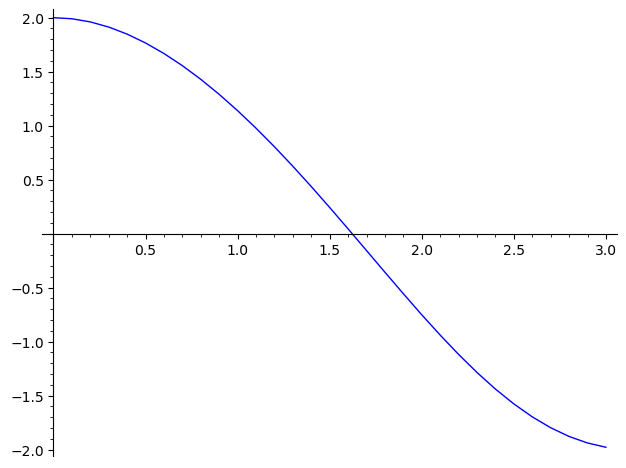

In [7]:
sol.plot_xt(t2=3)

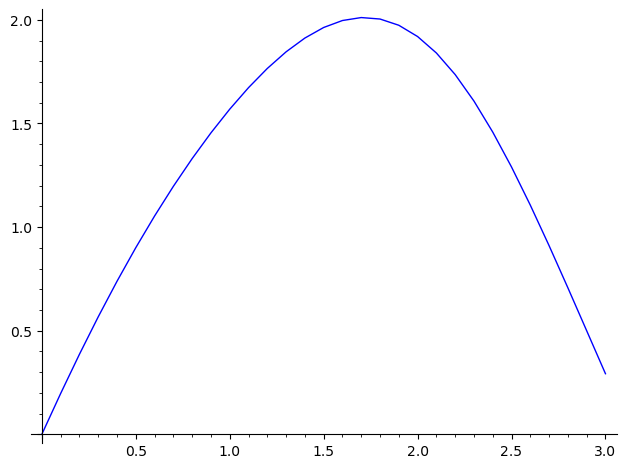

In [8]:
sol.plot_yt(t2=3)

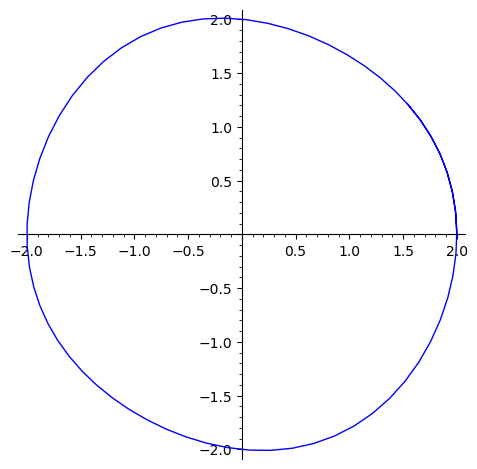

In [9]:
sol.plot_xy().show(aspect_ratio=1)

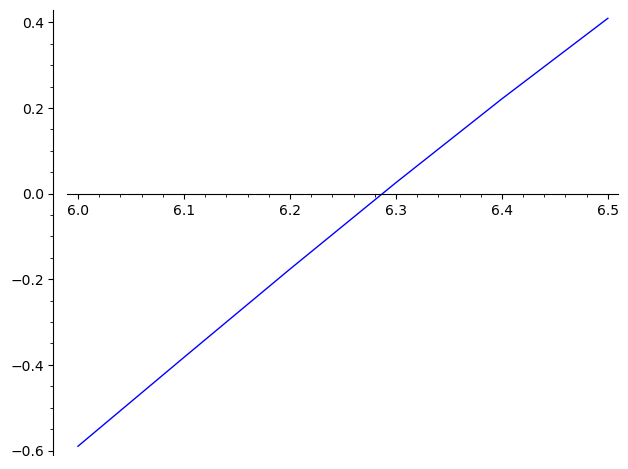

In [10]:
sol.plot_yt(6,6.5)

In [11]:
t1 = 6
t2 = 7
mu0 = 1
sol.set_params({mu : mu0})
findT(sol,t1,t2)

[[6.651634972080001, 2.00861423143392, -2.22996340174941e-12],
 [6.651634972090001, 2.00861423143392, 1.78561789123527e-11]]

In [44]:
retorn_values = []
for i in srange(1.995,2.006,0.001):
    retorn_values.append([i,retorn(sol,i,t1,t2)-i])

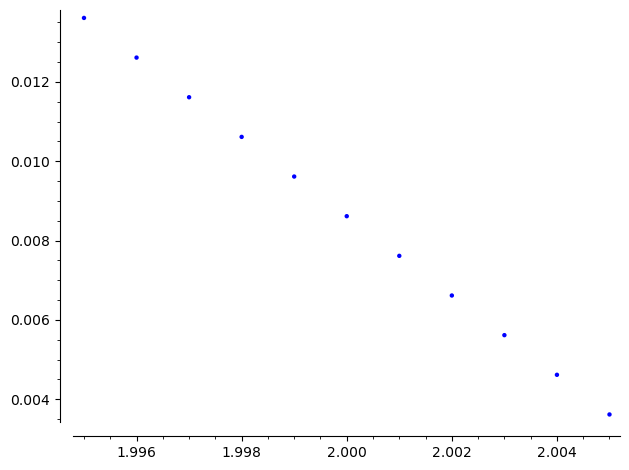

In [13]:
list_plot(retorn_values)

In [14]:
retorn_values

[[1.99500000000000, 0.01360948903759196],
 [1.99600000000000, 0.012610448344335001],
 [1.99700000000000, 0.011611402228270062],
 [1.99800000000000, 0.010612350701434181],
 [1.99900000000000, 0.009613293746084217],
 [2.00000000000000, 0.008614231433920594],
 [2.00100000000000, 0.007615163746826692],
 [2.00200000000000, 0.006616090696681454],
 [2.00300000000000, 0.005617012295316748],
 [2.00400000000000, 0.004617928554532913],
 [2.00500000000000, 0.003618839486096981]]

## Apartat (a)

In [104]:
var('x y t mu')
xp = y
yp = -x+mu*(1-x^2)*y
ICS = [0,2,0]
mu0 = 0
stepl = 0.01
tfin = 7
sol = Odesol([x,y],t,[xp,yp],{mu : mu0}, ics=ICS)
sol.solve(7)

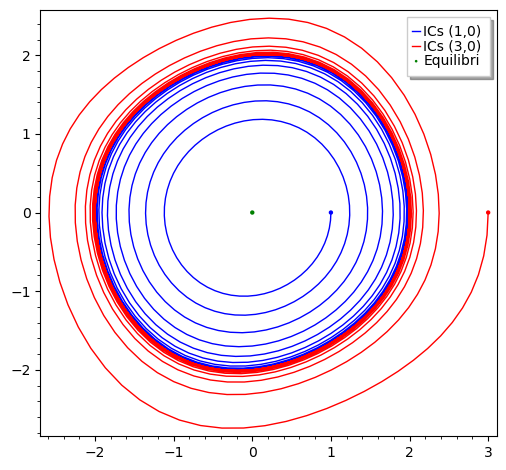

In [100]:
# Comprovem que es atractora
sol.set_params({mu:0.1})
sol.set_ics([0,1,0])
sol.solve(100)
atractor_in = sol.plot_xy(legend_label='ICs (1,0)')
sol.set_ics([0,3,0])
sol.solve(100)
atractor_out = sol.plot_xy(color='red',legend_label='ICs (3,0)')
atractor = atractor_in+atractor_out+ point2d([3,0],size=10,color='red') + point2d([1,0],size=10) + point2d([0,0],color='green',frame=True,axes=False,aspect_ratio=1,size=10, legend_label='Equilibri')
atractor

In [101]:
# atractor.save('prova_atractor.pdf')

In [105]:
# Per les mateixes condicions incials mirem com canvia l'orbita segons augmenta mu
plots = []
cmap = colormaps['hsv']
mu1 = 0
mu2 = 1.0
mu_step = 0.1
for i in srange(mu1,mu2+mu_step,mu_step):
    sol.set_params({mu : i}),
    sol.solve(7,step=0.01,update=False)
    sol.update_xy()
    plots.append(sol.plot_xy(color=cmap(int((i-mu1)/(mu2-mu1)*200))[:-1],legend_label=str(i.n(digits=1))))

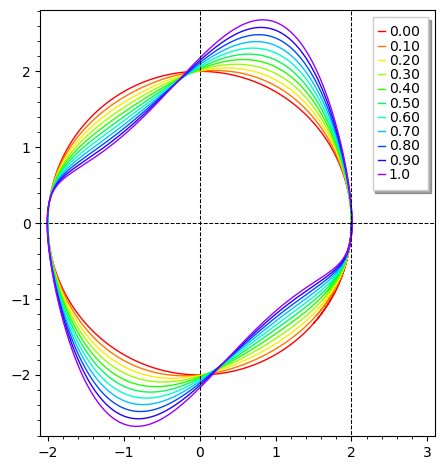

In [108]:
hsv_plot = (sum(plots)+line([(2,-3),(2,3)],color='black',linestyle='--',thickness='0.75') + line([(0,-3),(0,3)],color='black',linestyle='--',thickness='0.75')
 + line([(-3,0),(4,0)],color='black',linestyle='--',thickness='0.75',aspect_ratio=1,xmax=3,ymin=-2.7,ymax=2.7,xmin=-2,frame=True,axes=False))
hsv_plot

In [109]:
# hsv_plot.save('diverses_mu_rho2.pdf')

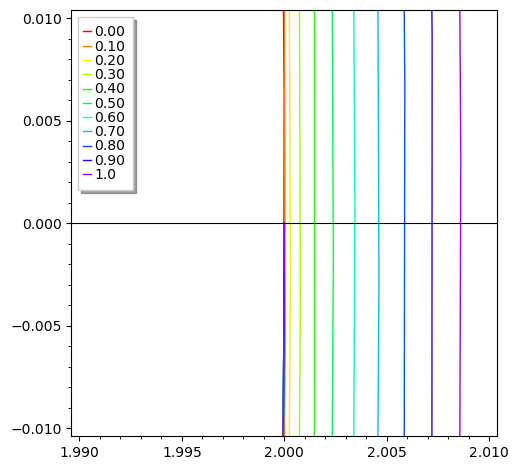

In [111]:
hsv_plot_closeup = sum(plots) + point2d([2,0],color='black',size=1,aspect_ratio=1,xmax=2.01,ymin=-0.01,ymax=0.01,xmin=1.99,frame=True)
hsv_plot_closeup

In [112]:
# hsv_plot_closeup.save('diverses_mu_rho2_closeup.pdf')

Comprovem l'existència gràficament de l'òrbita periòdica

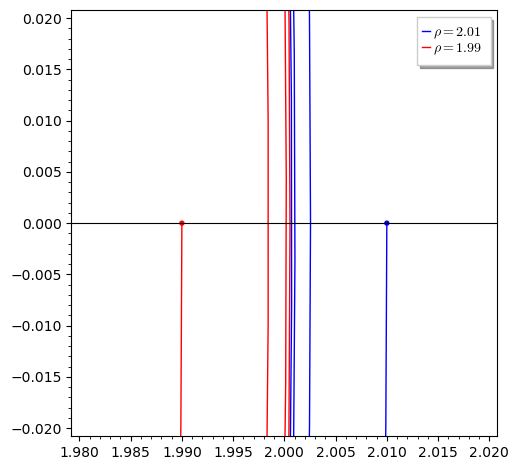

In [119]:
mu0 = 0.25
sol.set_params({mu:mu0})
sol.set_ics([0,2.01,0])
sol.solve(25,update=False)
sol.update_xy()
P1 = sol.plot_xy(legend_label=r'$\rho = 2.01$')
sol.set_ics([0,1.99,0])
sol.solve(25,update=False)
sol.update_xy()
P2 = sol.plot_xy(color='red', legend_label=r'$\rho = 1.99$')
exist_025 = P1+P2+point2d([2.01,0],size=15)+point2d([1.99,0],aspect_ratio=1,xmax=2.02,ymin=-0.02,ymax=0.02,xmin=1.98,frame=True,color='red',size=15)
exist_025

In [120]:
# exist_025.save('existencia_025.pdf')

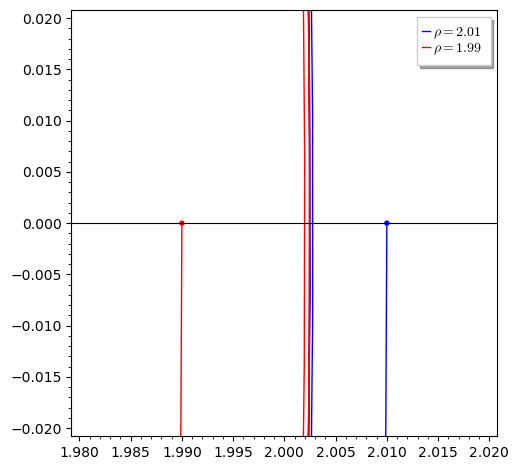

In [121]:
mu0 = 0.5
sol.set_params({mu:mu0})
sol.set_ics([0,2.01,0])
sol.solve(25,update=False)
sol.update_xy()
P1 = sol.plot_xy(legend_label=r'$\rho = 2.01$')
sol.set_ics([0,1.99,0])
sol.solve(25,update=False)
sol.update_xy()
P2 = sol.plot_xy(color='red', legend_label=r'$\rho = 1.99$')
exist_050 = (P1+P2)+point2d([2.01,0],size=15)+point2d([1.99,0],aspect_ratio=1,xmax=2.02,ymin=-0.02,ymax=0.02,xmin=1.98,frame=True,color='red',size=15)
exist_050

In [122]:
# exist_050.save('existencia_050.pdf')

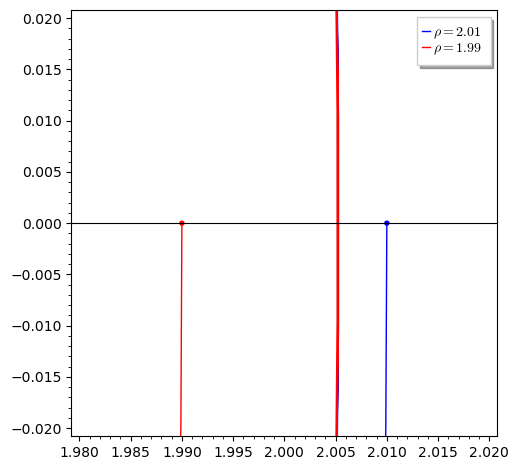

In [124]:
mu0 = 0.75
sol.set_params({mu:mu0})
sol.set_ics([0,2.01,0])
sol.solve(25,update=False)
sol.update_xy()
P1 = sol.plot_xy(legend_label=r'$\rho = 2.01$')
sol.set_ics([0,1.99,0])
sol.solve(25,update=False)
sol.update_xy()
P2 = sol.plot_xy(color='red', legend_label=r'$\rho = 1.99$')
exist_075 = (P1+P2)+point2d([2.01,0],size=15)+point2d([1.99,0],aspect_ratio=1,xmax=2.02,ymin=-0.02,ymax=0.02,xmin=1.98,frame=True,color='red',size=15)
exist_075

In [125]:
# exist_075.save('existencia_075.pdf')

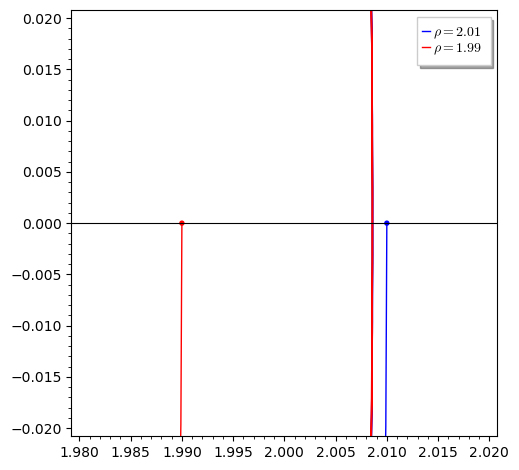

In [126]:
mu0 = 1
sol.set_params({mu:mu0})
sol.set_ics([0,2.01,0])
sol.solve(25,update=False)
sol.update_xy()
P1 = sol.plot_xy(legend_label=r'$\rho = 2.01$')
sol.set_ics([0,1.99,0])
sol.solve(25,update=False)
sol.update_xy()
P2 = sol.plot_xy(color='red', legend_label=r'$\rho = 1.99$')
exist_100 = (P1+P2)+point2d([2.01,0],size=15)+point2d([1.99,0],aspect_ratio=1,xmax=2.02,ymin=-0.02,ymax=0.02,xmin=1.98,frame=True,color='red',size=15)
exist_100

In [127]:
# exist_100.save('existencia_100.pdf')

## Apartat (b), (c)

Fixem $\mu = 0.1$

In [128]:
mu0 = 0.1
sol.set_params({mu:mu0})

In [129]:
sol.ics

[0, 1.99000000000000, 0]

In [130]:
t1 = 6
t2 = 7
findT(sol,t1,t2)

[[6.286525817988998, 1.994698330329207, 1.01851413007234e-12],
 [6.286525817989998, 1.994698330329207, -9.7618420025687e-13]]

In [131]:
retorn_values = []
for i in srange(1.8,2.25,0.05):
    retorn_values.append([i,retorn(sol,i,t1,t2)])

In [135]:
retorn_values

[[1.80000000000000, 1.885484020059157],
 [1.85000000000000, 1.915657654829436],
 [1.90000000000000, 1.944790361526161],
 [1.95000000000000, 1.972911056382316],
 [2.00000000000000, 2.000048549426404],
 [2.05000000000000, 2.026231442407877],
 [2.10000000000000, 2.051488040595398],
 [2.15000000000000, 2.075846277233495],
 [2.20000000000000, 2.099333649451748]]

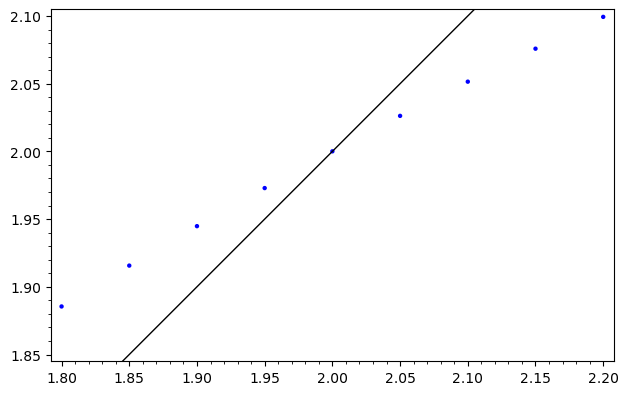

In [136]:
(list_plot(retorn_values)+ line([[1,1],[3,3]],color='black')).show(aspect_ratio=1, xmax = 2.2, xmin=1.8, ymax=2.1, ymin = 1.85, frame=True, axes=True)

In [137]:
retorn_values_close = []
for i in srange(1.995,2.006,0.001):
    retorn_values_close.append([i,retorn(sol,i,t1,t2)])

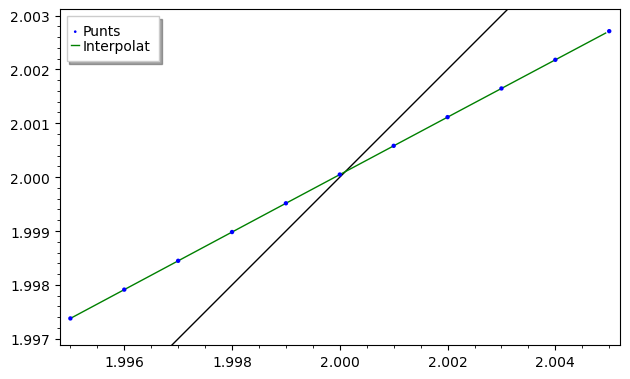

In [156]:
retorn_plot_close =  list_plot(retorn_values_close, legend_label='Punts',zorder=13) \
    + line([[1,1],[3,3]],color='black', aspect_ratio=1, xmax = 2.005, xmin=1.995,ymax=2.003,ymin=1.997, frame=True, axes=True,zorder=10) \
        + plot(spline(retorn_values_close),xmax = 2.005, xmin=1.995,color='green',legend_label='Interpolat',zorder=11) 
retorn_plot_close

In [157]:
# retorn_plot_close.save('retorn_plot_close.pdf')

Construim els punts de l'aplicació desplaçament

In [139]:
desp = [(p[0],p[1]-p[0]) for p in retorn_values]
desp_close = [(p[0],p[1]-p[0]) for p in retorn_values_close]

In [148]:
# Exportem la taula per 'close'
retorn_table = [retorn_values_close[i]+[desp_close[i][1]] for i in range(len(retorn_values_close))]
latex(table(retorn_table, align='center', frame=True))

\begin{tabular}{|c|c|c|} \hline
$1.99500000000000$ & $1.997378226999454$ & $0.002378226999453892$ \\ \hline
$1.99600000000000$ & $1.997913056512247$ & $0.0019130565122469356$ \\ \hline
$1.99700000000000$ & $1.998447503283406$ & $0.0014475032834060375$ \\ \hline
$1.99800000000000$ & $1.998981567540889$ & $0.0009815675408892943$ \\ \hline
$1.99900000000000$ & $1.999515249512599$ & $0.0005152495125992917$ \\ \hline
$2.00000000000000$ & $2.000048549426404$ & $4.8549426404420615 \times 10^{-05}$ \\ \hline
$2.00100000000000$ & $2.000581467510117$ & $-0.00041853248988266145$ \\ \hline
$2.00200000000000$ & $2.001114003991511$ & $-0.0008859960084883767$ \\ \hline
$2.00300000000000$ & $2.001646159098295$ & $-0.0013538409017042063$ \\ \hline
$2.00400000000000$ & $2.002177933058147$ & $-0.001822066941852274$ \\ \hline
$2.00500000000000$ & $2.00270932609869$ & $-0.0022906739013088817$ \\ \hline
\end{tabular}

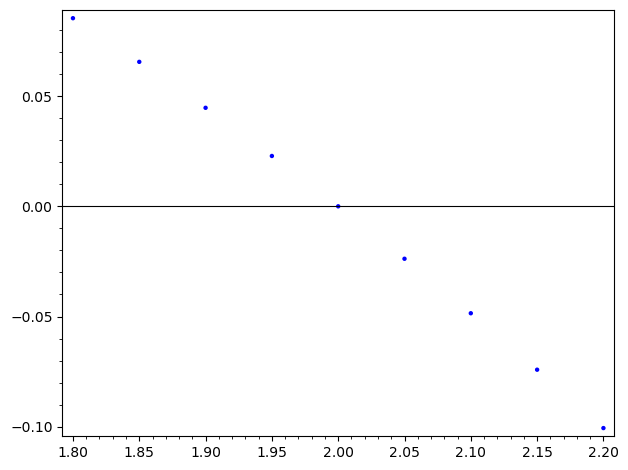

In [140]:
list_plot(desp).show(frame=True)

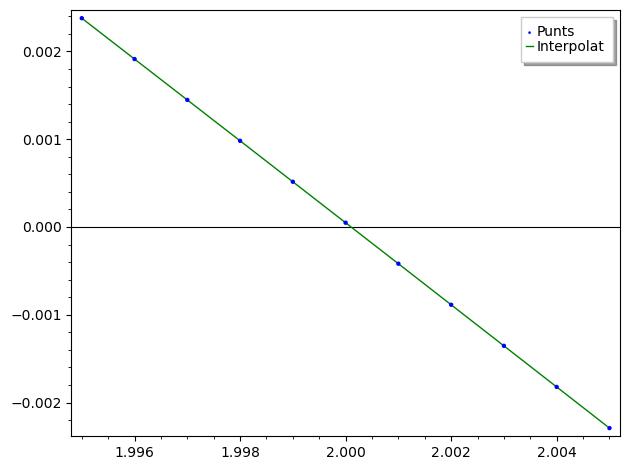

In [159]:
desp_plot_close = list_plot(desp_close, legend_label='Punts', frame=True, zorder=12) + plot(spline(desp_close),xmax = 2.005, xmin=1.995,color='green',legend_label='Interpolat',zorder=11)
desp_plot_close

In [160]:
# desp_plot_close.save('desp_plot_close.pdf')

In [41]:
# Trobem el zero via interpolacio
S_desp = spline(desp_close)
find_root(S_desp, 1.996,2.002)

2.000103980057892

## Apartat (d)

In [223]:
mu_list = srange(0.1,1.1,0.1)

In [189]:
# Tarda uns 110s en executar-se
results = [[n(2*pi),2,2,0,0]]
for i in range(len(mu_list)):
    sol.set_params({mu:mu_list[i]})
    bounds = [results[i][1]-0.1,results[i][1]+0.1, results[i][0]-0.5,results[i][0]+0.5]
    results.append(find_T_p(sol,bounds[0],bounds[1],bounds[2],bounds[3]))



NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.

NaN result encountered.


In [190]:
results

[[6.28318530717959, 2, 2, 0],
 [6.287111273039998,
  2.0001039832137493,
  2.000103981745201,
  -2.45634372606079e-13,
  1.000088900582341e-12],
 [6.298876715504,
  2.000413684459734,
  2.00041368069507,
  -2.09257634467105e-13,
  1.000088900582341e-12],
 [6.318443206021001,
  2.0009223908049925,
  2.000922386547405,
  -6.45325112523655e-13,
  1.0009770790020411e-12],
 [6.345743280027,
  2.0016189619512343,
  2.001618958230553,
  9.86352499175055e-13,
  9.992007221626409e-13],
 [6.380675805483,
  2.002487933751345,
  2.00248793091123,
  -6.30884423866951e-13,
  1.000088900582341e-12],
 [6.423100487454,
  2.003509744156188,
  2.003509742183558,
  -3.83760037839291e-13,
  9.992007221626409e-13],
 [6.472832478167,
  2.0046611361178974,
  2.004661134853061,
  -6.99489597646761e-13,
  1.000088900582341e-12],
 [6.529638245561,
  2.005915789894794,
  2.0059157891423,
  9.81885555878259e-13,
  1.000088900582341e-12],
 [6.593233885827002,
  2.007245211617949,
  2.007245211203697,
  -3.617836908

In [218]:
len(results)

11

In [227]:
mu_list = [0] + [n(i, digits=2) for i in mu_list]

In [228]:
mu_list

[0, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 1.0]

In [229]:
mu_T_rho = [(mu_list[i],RR(results[i][0]).n(digits=7),RR(results[i][1]).n(digits=7)) for i in range(len(results))]

In [230]:
mu_T_rho_err = [(mu_list[i],RR(results[i][0]).n(digits=13),RR(results[i][4]).n(digits=2),RR(results[i][1]).n(digits=11),RR(abs(results[i][1]-results[i][2])).n(digits=2)) for i in range(len(results))]

In [231]:
mu_T_rho_err

[(0, 6.283185307180, 0.00, 2.0000000000, 0.00),
 (0.10, 6.287111273040, 1.0e-12, 2.0001039832, 1.5e-9),
 (0.20, 6.298876715504, 1.0e-12, 2.0004136845, 3.8e-9),
 (0.30, 6.318443206021, 1.0e-12, 2.0009223908, 4.3e-9),
 (0.40, 6.345743280027, 1.0e-12, 2.0016189620, 3.7e-9),
 (0.50, 6.380675805483, 1.0e-12, 2.0024879338, 2.8e-9),
 (0.60, 6.423100487454, 1.0e-12, 2.0035097442, 2.0e-9),
 (0.70, 6.472832478167, 1.0e-12, 2.0046611361, 1.3e-9),
 (0.80, 6.529638245561, 1.0e-12, 2.0059157899, 7.5e-10),
 (0.90, 6.593233885827, 1.0e-12, 2.0072452116, 4.1e-10),
 (1.0, 6.663286868362, 1.0e-12, 2.0086198618, 2.1e-10)]

In [232]:
latex(table(mu_T_rho_err,align='center',frame=True))

\begin{tabular}{|c|c|c|c|c|} \hline
$0$ & $6.283185307180$ & $0.00$ & $2.0000000000$ & $0.00$ \\ \hline
$0.10$ & $6.287111273040$ & $1.0 \times 10^{-12}$ & $2.0001039832$ & $1.5 \times 10^{-9}$ \\ \hline
$0.20$ & $6.298876715504$ & $1.0 \times 10^{-12}$ & $2.0004136845$ & $3.8 \times 10^{-9}$ \\ \hline
$0.30$ & $6.318443206021$ & $1.0 \times 10^{-12}$ & $2.0009223908$ & $4.3 \times 10^{-9}$ \\ \hline
$0.40$ & $6.345743280027$ & $1.0 \times 10^{-12}$ & $2.0016189620$ & $3.7 \times 10^{-9}$ \\ \hline
$0.50$ & $6.380675805483$ & $1.0 \times 10^{-12}$ & $2.0024879338$ & $2.8 \times 10^{-9}$ \\ \hline
$0.60$ & $6.423100487454$ & $1.0 \times 10^{-12}$ & $2.0035097442$ & $2.0 \times 10^{-9}$ \\ \hline
$0.70$ & $6.472832478167$ & $1.0 \times 10^{-12}$ & $2.0046611361$ & $1.3 \times 10^{-9}$ \\ \hline
$0.80$ & $6.529638245561$ & $1.0 \times 10^{-12}$ & $2.0059157899$ & $7.5 \times 10^{-10}$ \\ \hline
$0.90$ & $6.593233885827$ & $1.0 \times 10^{-12}$ & $2.0072452116$ & $4.1 \times 10^{-10}$ \\ \

## Apartat (e)

In [233]:
mu_T = [(i,j) for i,j,k in mu_T_rho]
mu_rho = [(i,k) for i,j,k in mu_T_rho]
T_rho = [(j,k) for i,j,k in mu_T_rho]

Plot $(\mu, T_{\mu})$

verbose 0 (3899: plot.py, generate_plot_points) WARNING: When plotting, failed to evaluate function at 100 points.
verbose 0 (3899: plot.py, generate_plot_points) Last error message: 'Unable to compute f(-0.001077536342761344)'


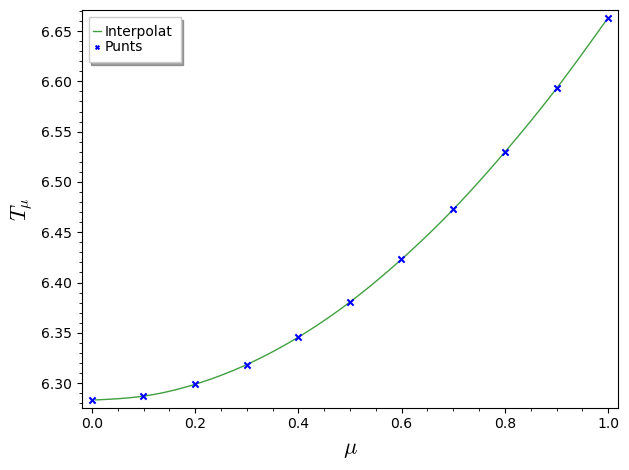

In [242]:
mu_T_plot = plot(spline(mu_T),color='green', legend_label="Interpolat",zorder=10, alpha=0.75, frame=True, axes=False, axes_labels=[r'$\mu$',r'$T_\mu$']) + list_plot(mu_T,legend_label="Punts", marker='x', size=20, zorder=12)
mu_T_plot

Plot $(\mu, \rho_\mu)$

verbose 0 (3899: plot.py, generate_plot_points) WARNING: When plotting, failed to evaluate function at 100 points.
verbose 0 (3899: plot.py, generate_plot_points) Last error message: 'Unable to compute f(-0.0004186776352711136)'


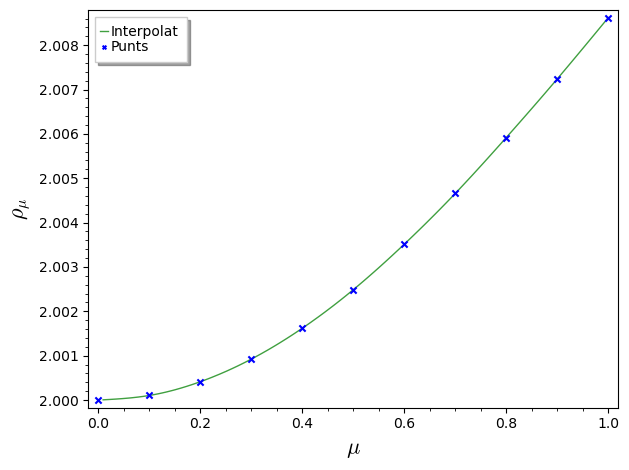

In [241]:
mu_rho_plot = plot(spline(mu_rho),color='green', legend_label="Interpolat",zorder=10, alpha=0.75, frame=True, axes=False, axes_labels=[r'$\mu$',r'$\rho_\mu$']) + list_plot(mu_rho,legend_label="Punts", marker='x', size=20, zorder=12)
mu_rho_plot

Plot $(T_\mu, \rho_\mu)$

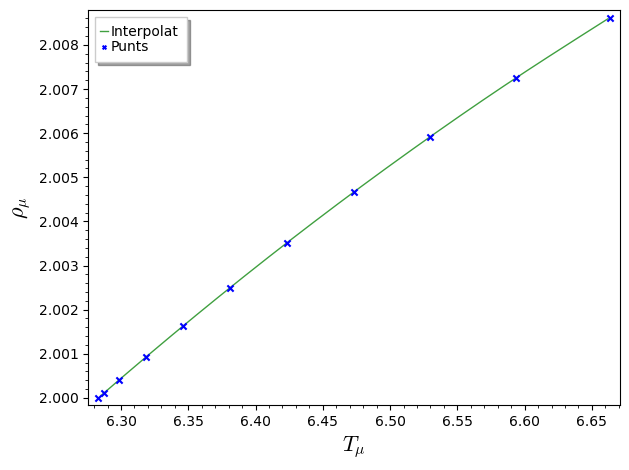

In [240]:
T_rho_plot = plot(spline(T_rho),color='green', legend_label="Interpolat",zorder=10, alpha=0.75,xmin=6.2831, xmax=6.664,frame=True, axes=False, axes_labels=[r'$T_\mu$',r'$\rho_\mu$']) + list_plot(T_rho,legend_label="Punts", marker='x', size=20, zorder=12)
T_rho_plot

In [244]:
# T_rho_plot.save('T_rho_plot.pdf')
# mu_rho_plot.save('mu_rho_plot.pdf')
# mu_T_plot.save('mu_T_plot.pdf')

# Exercici 2

## Tests

In [231]:
T = ode_solver()

In [238]:
def f_1 (t, y, params): 
    return [-y[1], y[0]+params[0]*(1-y[0]*y[0])*y[1]]

def j_1(t, y, params):
   return [[0.0, -1.0],
           [-2.0*params[0]*y[0]*y[1] + 1.0, params[0]*(-y[0]*y[0]+1.0)],
           [0.0, 0.0]]

In [239]:
T.function = f_1
T.algorithm = 'rkf45'

In [240]:
T.ode_solve(y_0=[2,0],t_span=[0,7], params=[0.1],num_points=1000)

In [242]:
var('x y t mu')
xp = -y
yp = x+mu*(1-x^2)*y
ICS = [0.,2.,0.]
mu0 = 0
stepl = 7./1000
tfin = 7.
sol1 = Odesol([x,y],t,[xp,yp],{mu : mu0}, ics=ICS)
sol1.set_step(stepl)

In [249]:
timeit('T.ode_solve(y_0=[2,0],t_span=[0,7], params=[0.1],num_points=1000)')

5 loops, best of 3: 53.6 ms per loop

In [250]:
timeit('sol.solve(7,update=False)')

5 loops, best of 3: 167 ms per loop

In [236]:
sol1.sol

[[0.000000000000000, 2.00000000000000, 0.000000000000000],
 [0.007, 1.999951000200083, 0.01399988566666667],
 [0.014, 1.999804003201317, 0.02799908534173681],
 [0.021, 1.999559016206524, 0.04199691306722738],
 [0.028, 1.999216051220019, 0.05599268295238059],
 [0.035, 1.998775125047018, 0.0699857092072724],
 [0.042, 1.998236259292814, 0.08397530617641612],
 [0.049, 1.997599480361721, 0.09796078837235936],
 [0.056, 1.996864819455781, 0.1119414705092728],
 [0.063, 1.99603231257323, 0.1259166675365291],
 [0.07, 1.995102000506739, 0.1398856946722701],
 [0.077, 1.994073928841412, 0.1538478674369612],
 [0.084, 1.992948147952557, 0.1678025016869304],
 [0.091, 1.991724713003211, 0.1817489136478918],
 [0.098, 1.990403683941443, 0.1956864199484496],
 [0.105, 1.98898512549741, 0.2096143376535838],
 [0.112, 1.987469107180195, 0.2235319842981137],
 [0.119, 1.985855703274391, 0.2374386779201383],
 [0.126, 1.984144992836466, 0.2513337370944527],
 [0.133, 1.982337059690889, 0.2652164809659376],
 [0.14,

In [237]:
sol1.sol

[[0.000000000000000, 2.00000000000000, 0.000000000000000],
 [0.007, 1.999951000200083, 0.01399988566666667],
 [0.014, 1.999804003201317, 0.02799908534173681],
 [0.021, 1.999559016206524, 0.04199691306722738],
 [0.028, 1.999216051220019, 0.05599268295238059],
 [0.035, 1.998775125047018, 0.0699857092072724],
 [0.042, 1.998236259292814, 0.08397530617641612],
 [0.049, 1.997599480361721, 0.09796078837235936],
 [0.056, 1.996864819455781, 0.1119414705092728],
 [0.063, 1.99603231257323, 0.1259166675365291],
 [0.07, 1.995102000506739, 0.1398856946722701],
 [0.077, 1.994073928841412, 0.1538478674369612],
 [0.084, 1.992948147952557, 0.1678025016869304],
 [0.091, 1.991724713003211, 0.1817489136478918],
 [0.098, 1.990403683941443, 0.1956864199484496],
 [0.105, 1.98898512549741, 0.2096143376535838],
 [0.112, 1.987469107180195, 0.2235319842981137],
 [0.119, 1.985855703274391, 0.2374386779201383],
 [0.126, 1.984144992836466, 0.2513337370944527],
 [0.133, 1.982337059690889, 0.2652164809659376],
 [0.14,

In [52]:
T.solution

NameError: name 'T' is not defined

## Resolució

In [245]:
var('x y t a b c')
# Sistema desplaçat original
xpo = -x+b*y+y^2
ypo = a*x-a*b*y-x*y+c*(-x+b*y+y^2)

In [246]:
# Equilibris amb parametres
solve([xpo,ypo], x,y)

[[x == a^2 - a*b, y == a - b], [x == 0, y == 0]]

In [247]:
xp = xpo.subs(y=y+a-b, x=x+a^2-a*b)
yp =  ypo.subs(y=y+a-b, x=x+a^2-a*b)

In [256]:
latex(yp.simplify_full())

c y^{2} + {\left(b - c\right)} x - {\left(a^{2} - {\left(2 \, a - b\right)} c + x\right)} y

In [248]:
# Equilibri que volem centrat al zero
solve([xp,yp], x,y)

[[x == -a^2 + a*b, y == -a + b], [x == 0, y == 0]]

In [263]:
f = (xp,yp)
print(jacobian(f, (x,y)).subs(x=0,y=0,a=1,b=-1,c=3/4).eigenvalues())
jacobian(f, (x,y)).subs(x=-2,y=-2,a=1,b=-1,c=3/4).eigenvalues()

[-1/8*I*sqrt(255) + 1/8, 1/8*I*sqrt(255) + 1/8]


[-3/4, 0]

In [286]:
a0 = 1
b0 = -1
c0 = 3./4.
params = {a:a0, b:b0, c:c0}
ICS = [0.,1,1]
stepl = 0.1
tfin = 25.
sol1 = Odesol([x,y],t,[xp,yp],params, ics=ICS)

In [287]:
# Equilibris
solve([xp.subs(params),yp.subs(params)], x,y)

[[x == -2, y == -2], [x == 0, y == 0]]

In [288]:
sol1.solve(tfin,step=0.01)

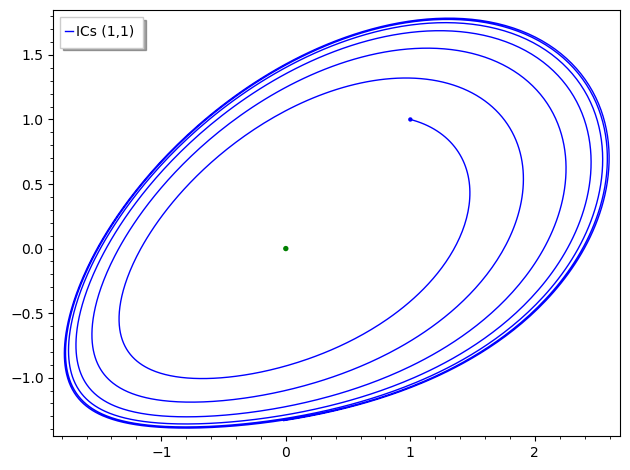

In [289]:
sol_temptativa1 = sol1.plot_xy(legend_label='ICs (1,1)') + points([[0,0]], color='green', size=15, axes=False, frame=True,) + point2d([1,1])
sol_temptativa1

In [290]:
sol1.set_ics([0,2,2])
sol1.solve(tfin,step=0.01)

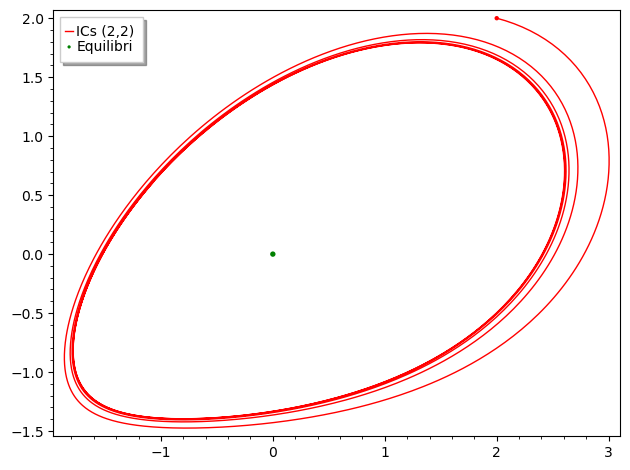

In [291]:
sol_temptativa2 = sol1.plot_xy(color='red',legend_label='ICs (2,2)') + points([[0,0]], color='green', size=15, axes=False, frame=True,legend_label='Equilibri') + point2d([2,2],color='red')
sol_temptativa2

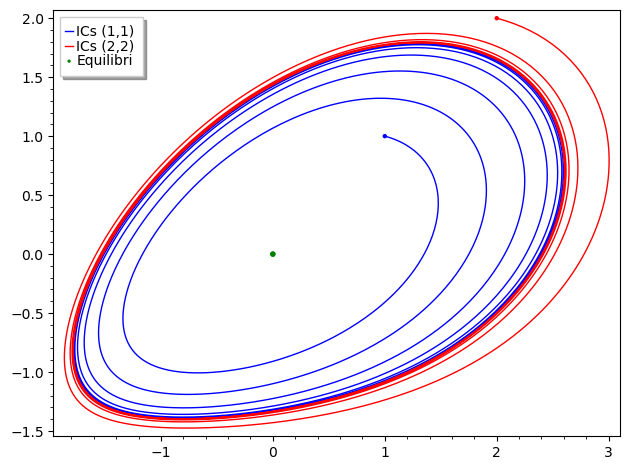

In [292]:
sol_temptativa = sol_temptativa1 + sol_temptativa2
sol_temptativa

In [293]:
# sol_temptativa.save('solucio_temptativa.pdf')

In [294]:
# We get closer
new_ics = [0,0,1.4]
sol1.set_ics(new_ics)
sol1.solve(4.5)

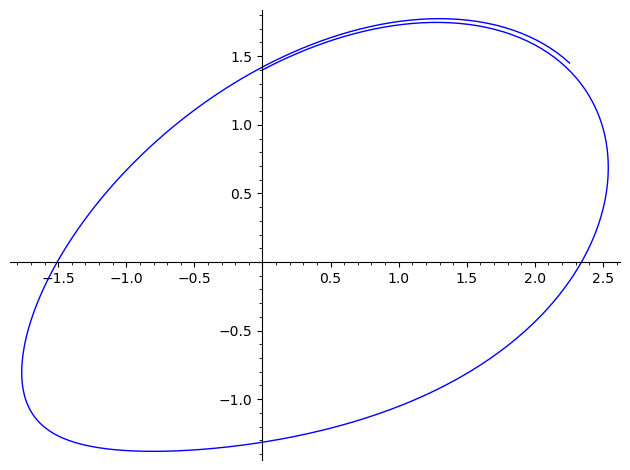

In [295]:
sol1.plot_xy()

In [296]:
sol1.set_ics([0,0,1.4])
findT(sol1,3.5,5,coord=1)

[[4.154938713435, -2.28057081241103e-12, 1.421189370903564],
 [4.154938713436, 4.00277652827768e-12, 1.421189370906855]]

In [297]:
rho_list = [1.4]
for i in range(30):
    rho_list.append(retorn(sol1,rho_list[i],3.9,4.2,coord=1))

In [299]:
rho_list[-15:]

[1.433951961526524,
 1.43395196373495,
 1.433951964540357,
 1.433951964834078,
 1.433951964940662,
 1.433951964980116,
 1.433951964993188,
 1.433951964998921,
 1.433951965000957,
 1.433951965001239,
 1.433951965003687,
 1.433951965002684,
 1.4339519650025,
 1.433951965003069,
 1.433951965001293]

In [301]:
sol1.set_ics([0,0,rho_list[-1]])
T_period, x_error, rho_period = findT(sol1,4.1,4.2,coord=1)[0]

In [302]:
T_period

4.190705447113

In [303]:
rho_period

1.433951965000178

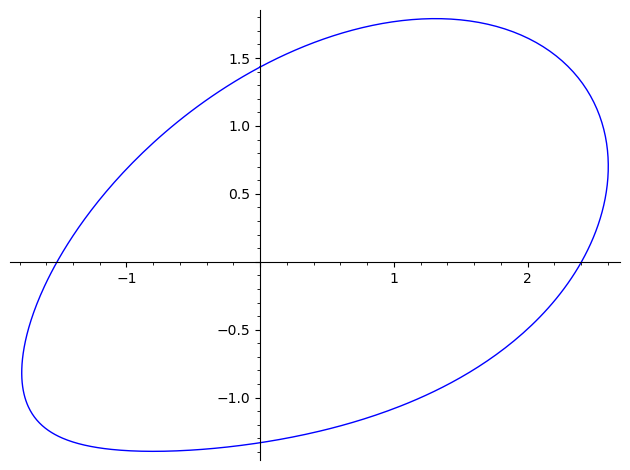

In [304]:
sol1.set_ics([0,0,rho_period])
sol1.solve(T_period)
sol1.plot_xy()

In [305]:
# Per tant, la intersecció entre l'orbita periodica i x=0 per y>0 és
intersect = (2,2+rho_period)
intersect

(2, 3.433951965000178)

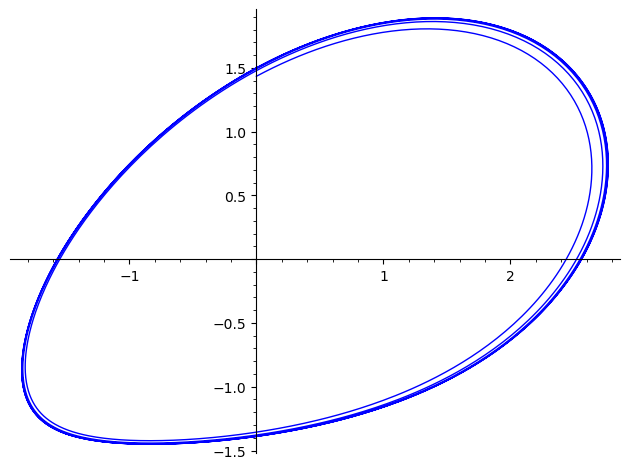

In [306]:
temp_rho = rho_period
c1 = 3./4.+0.01
sol1.set_params({a:a0,b:b0,c:c1})
sol1.set_ics([0,0,temp_rho])
sol1.solve(25)
sol1.plot_xy()

In [308]:
c_list_up = srange(3/4+0.01, 3/4+0.06, 0.01)
c_list_down = srange(3/4-0.01, 3/4-0.06, -0.01)
intersect_cvar_up = [(3/4, rho_period, T_period,0)]
intersect_cvar_down = [(3/4, rho_period, T_period,0)]
# We go up the parameter
for i in range(len(c_list_up)):
    temp_rho_T = (intersect_cvar_up[i][1],intersect_cvar_up[i][2])
    sol1.set_params({a:a0, b:b0, c:c_list_up[i]})
    sol1.set_ics([0,0,temp_rho_T[0]])
    # We get closer to the periodic orbit
    for j in range(5):
        temp_rho_T = retorn(sol1, temp_rho_T[0], temp_rho_T[1]-0.2, temp_rho_T[1]+0.2, coord=1, time=True)
    error = abs(retorn(sol1, temp_rho_T[0], temp_rho_T[1]-0.2, temp_rho_T[1]+0.2, coord=1)-temp_rho_T[0])
    intersect_cvar_up.append((c_list_up[i], temp_rho_T[0], temp_rho_T[1],error))
# We go down the parameter
for i in range(len(c_list_down)):
    temp_rho_T = (intersect_cvar_down[i][1],intersect_cvar_down[i][2])
    sol1.set_params({a:a0, b:b0, c:c_list_down[i]})
    sol1.set_ics([0,0,temp_rho_T[0]])
    # We get closer to the periodic orbit
    for j in range(5):
        temp_rho_T = retorn(sol1, temp_rho_T[0], temp_rho_T[1]-0.2, temp_rho_T[1]+0.2, coord=1, time=True)
    error = abs(retorn(sol1, temp_rho_T[0], temp_rho_T[1]-0.2, temp_rho_T[1]+0.2, coord=1)-temp_rho_T[0])
    intersect_cvar_down.append((c_list_down[i], temp_rho_T[0], temp_rho_T[1],error))

In [309]:
intersect_cvar_down.reverse()
intersect_cvar = intersect_cvar_down[:-1] + intersect_cvar_up
intersect_cvar

[(0.700000000000000,
  0.9783215207269726,
  3.537221526644,
  0.0058227002800388394),
 (0.710000000000000, 1.090909461568129, 3.652534377766, 0.0034475952935879572),
 (0.720000000000000, 1.191225745537279, 3.776080481055, 0.0019324118723229589),
 (0.730000000000000, 1.280943217899544, 3.907225583885, 0.0010274931759368666),
 (0.740000000000000, 1.36155343653573, 4.045759232743, 0.0005161492761249775),
 (3/4, 1.433951965000178, 4.190705447113, 0),
 (0.760000000000000,
  1.499984053426937,
  4.344461653516,
  0.00014780726434393543),
 (0.770000000000000, 1.560348723870666, 4.507618475622, 6.246288590516791e-05),
 (0.780000000000000, 1.615425227318521, 4.679794769625, 2.484360362209337e-05),
 (0.790000000000000,
  1.665894750193706,
  4.862229941610002,
  9.3299398540303e-06),
 (0.800000000000000,
  1.712293564535513,
  5.056365662946,
  3.2893829748914527e-06)]

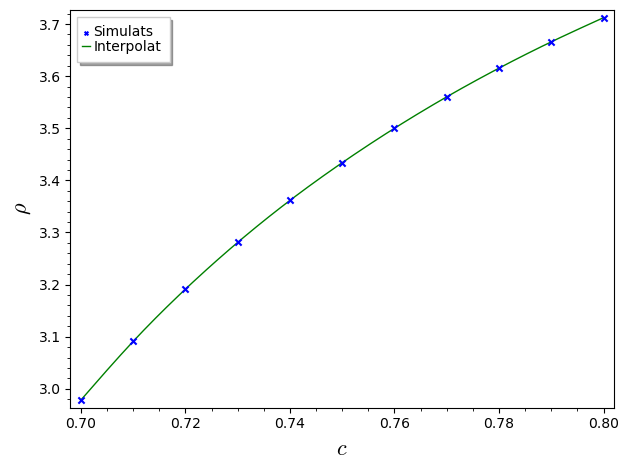

In [326]:
int_cvar_plot = [(i,j+2) for i,j,k,l in intersect_cvar]
PL_C = list_plot(int_cvar_plot,marker='x', size=20, legend_label='Simulats',frame=True,axes_labels=[r'$c$',r'$\rho$'],zorder=12) + plot(spline(int_cvar_plot),xmin=0.7,xmax=0.8,color='green',legend_label='Interpolat',zorder=10)
PL_C

Fem el mateix per $a$

In [311]:
a_list_up = srange(1+0.01, 1+0.06, 0.01)
a_list_down = srange(1-0.01, 1-0.06, -0.01)
intersect_avar_up = [(1, rho_period, T_period,0)]
intersect_avar_down = [(1, rho_period, T_period,0)]
# We go up
for i in range(len(a_list_up)):
    temp_rho_T = (intersect_avar_up[i][1],intersect_avar_up[i][2])
    sol1.set_params({a:a_list_up[i], b:b0, c:c0})
    sol1.set_ics([0,0,temp_rho_T[0]])
    # We get closer to the periodic orbit
    for j in range(5):
        temp_rho_T = retorn(sol1, temp_rho_T[0], temp_rho_T[1]-0.2, temp_rho_T[1]+0.2, coord=1, time=True)
    error = abs(retorn(sol1, temp_rho_T[0], temp_rho_T[1]-0.2, temp_rho_T[1]+0.2, coord=1)-temp_rho_T[0])
    intersect_avar_up.append((a_list_up[i], temp_rho_T[0], temp_rho_T[1],error))
# We go down
for i in range(len(a_list_down)):
    temp_rho_T = (intersect_avar_down[i][1],intersect_avar_down[i][2])
    sol1.set_params({a:a_list_down[i], b:b0, c:c0})
    sol1.set_ics([0,0,temp_rho_T[0]])
    # We get closer to the periodic orbit
    for j in range(5):
        temp_rho_T = retorn(sol1, temp_rho_T[0], temp_rho_T[1]-0.2, temp_rho_T[1]+0.2, coord=1, time=True)
    error = abs(retorn(sol1, temp_rho_T[0], temp_rho_T[1]-0.2, temp_rho_T[1]+0.2, coord=1)-temp_rho_T[0])
    intersect_avar_down.append((a_list_down[i], temp_rho_T[0], temp_rho_T[1],error))

In [312]:
intersect_avar_down.reverse()
intersect_avar = intersect_avar_down[:-1] + intersect_avar_up
intersect_avar

[(0.950000000000000,
  1.446615242937159,
  4.613466656936,
  1.5988325108295953e-07),
 (0.960000000000000,
  1.446707436296329,
  4.521801456437998,
  2.5281191109449708e-06),
 (0.970000000000000, 1.445496553725641, 4.433874335482, 6.317030704083848e-06),
 (0.980000000000000, 1.442968379839348, 4.349487034016, 1.147669952494823e-05),
 (0.990000000000000,
  1.439110201809617,
  4.268450588492999,
  1.8181145974072166e-05),
 (1, 1.433951965000178, 4.190705447113, 0),
 (1.01000000000000,
  1.427465670867718,
  4.116005727530001,
  3.1087527490925027e-05),
 (1.02000000000000,
  1.419590328034912,
  4.044058505842998,
  4.406834760795064e-05),
 (1.03000000000000, 1.410347444664383, 3.974805339938, 6.0206993928169084e-05),
 (1.04000000000000, 1.399725098444221, 3.908103372965, 8.032386346212839e-05),
 (1.05000000000000, 1.387709507854378, 3.843817666589, 0.00010520667419799956)]

/home/geragc/mambaforge/envs/sage/lib/python3.9/site-packages/sage/plot/point.py:314: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  subplot.scatter(self.xdata, self.ydata, s=s, c=c, alpha=a, zorder=z,


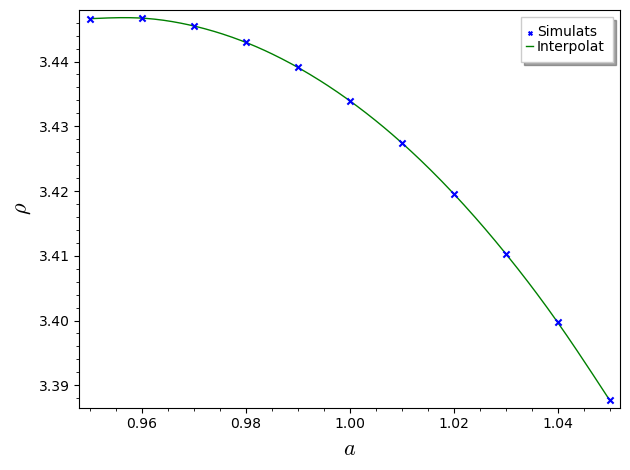

In [325]:
int_avar_plot = [(i,j+2) for i,j,k,l in intersect_avar]
PL_A = list_plot(int_avar_plot,marker='x', size=20, legend_label='Simulats',frame=True,axes_labels=[r'$a$',r'$\rho$'],zorder=12) + plot(spline(int_avar_plot),xmin=0.95,xmax=1.05,color='green',legend_label='Interpolat',zorder=10)
PL_A

Fem el mateix per $b$

In [315]:
b_list_up = srange(-1+0.01, -1+0.06, 0.01)
b_list_down = srange(-1-0.01, -1-0.06, -0.01)
intersect_bvar_up = [(-1, rho_period, T_period,0)]
intersect_bvar_down = [(-1, rho_period, T_period,0)]
# We go up
for i in range(len(b_list_up)):
    temp_rho_T = (intersect_bvar_up[i][1],intersect_bvar_up[i][2])
    sol1.set_params({a:a0, b:b_list_up[i], c:c0})
    sol1.set_ics([0,0,temp_rho_T[0]])
    # We get closer to the periodic orbit
    for j in range(5):
        temp_rho_T = retorn(sol1, temp_rho_T[0], temp_rho_T[1]-0.2, temp_rho_T[1]+0.2, coord=1, time=True)
    error = abs(retorn(sol1, temp_rho_T[0], temp_rho_T[1]-0.2, temp_rho_T[1]+0.2, coord=1)-temp_rho_T[0])
    intersect_bvar_up.append((b_list_up[i], temp_rho_T[0], temp_rho_T[1],error))
# We go down
for i in range(len(b_list_down)):
    temp_rho_T = (intersect_bvar_down[i][1],intersect_bvar_down[i][2])
    sol1.set_params({a:a0, b:b_list_down[i], c:c0})
    sol1.set_ics([0,0,temp_rho_T[0]])
    # We get closer to the periodic orbit
    for j in range(5):
        temp_rho_T = retorn(sol1, temp_rho_T[0], temp_rho_T[1]-0.2, temp_rho_T[1]+0.2, coord=1, time=True)
    error = abs(retorn(sol1, temp_rho_T[0], temp_rho_T[1]-0.2, temp_rho_T[1]+0.2, coord=1)-temp_rho_T[0])
    intersect_bvar_down.append((b_list_down[i], temp_rho_T[0], temp_rho_T[1],error))

Maxima crashed -- automatically restarting.


IOStream.flush timed out
IOStream.flush timed out


In [316]:
intersect_bvar_down.reverse()
intersect_bvar = intersect_bvar_down[:-1] + intersect_bvar_up
intersect_bvar

[(-1.05000000000000,
  1.557041986079382,
  4.231254761457,
  5.0761559734935346e-05),
 (-1.04000000000000,
  1.532726350280173,
  4.223608056440999,
  5.9044991776113775e-05),
 (-1.03000000000000, 1.508253253826707, 4.215681203727, 6.865831282487633e-05),
 (-1.02000000000000, 1.483612442969499, 4.207473926194, 7.980730506096378e-05),
 (-1.01000000000000, 1.458793819811476, 4.198989011019, 9.20957102599207e-05),
 (-1, 1.433951965000178, 4.190705447113, 0),
 (-0.990000000000000,
  1.408952128504047,
  4.182246951702999,
  0.00011439663212087225),
 (-0.980000000000000,
  1.383591129423148,
  4.173086231087999,
  0.00013325574784195382),
 (-0.970000000000000,
  1.358008640005899,
  4.163667610213001,
  0.00015422311733104266),
 (-0.960000000000000,
  1.332191315674707,
  4.153998207119999,
  0.000178374358710931),
 (-0.950000000000000,
  1.30612359913026,
  4.144082701521999,
  0.00020617739972395022)]

/home/geragc/mambaforge/envs/sage/lib/python3.9/site-packages/sage/plot/point.py:314: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  subplot.scatter(self.xdata, self.ydata, s=s, c=c, alpha=a, zorder=z,


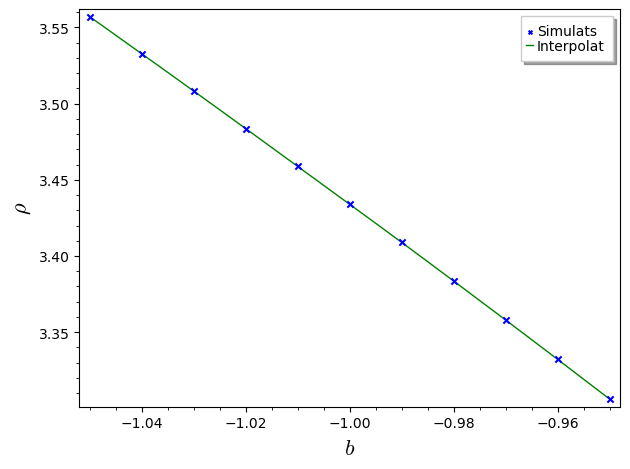

In [324]:
int_bvar_plot = [(i,j+2) for i,j,k,l in intersect_bvar]
PL_B = list_plot(int_bvar_plot,marker='x', size=20, legend_label='Simulats',frame=True,axes_labels=[r'$b$',r'$\rho$'],zorder=12) + plot(spline(int_bvar_plot),xmin=-1.05,xmax=-0.95,color='green',legend_label='Interpolat',zorder=10)
PL_B

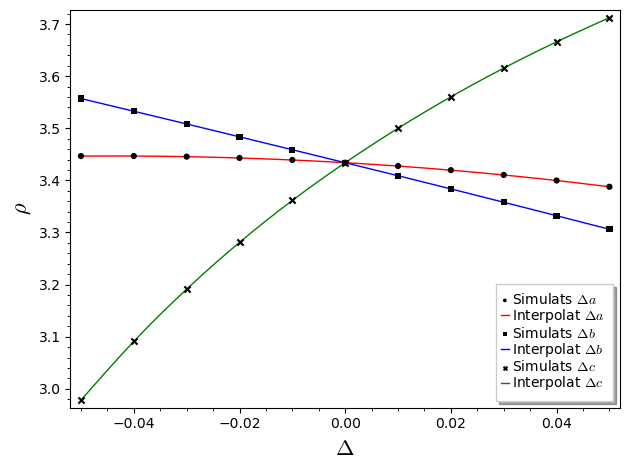

In [322]:
cint_cvar_plot = [(i-3/4,j) for i,j in int_cvar_plot]
cint_avar_plot = [(i-1,j) for i,j in int_avar_plot]
cint_bvar_plot = [(i+1,j) for i,j in int_bvar_plot]
interpol_c = spline(cint_cvar_plot)
interpol_a = spline(cint_avar_plot)
interpol_b = spline(cint_bvar_plot)
CPL_C = list_plot(cint_cvar_plot,marker='x', color='black', size=20, legend_label=r'Simulats $\Delta c$',frame=True, axes=False, zorder=12) + plot(interpol_c,xmin=-0.05,xmax=0.05,color='green',legend_label=r'Interpolat $\Delta c$', zorder=10)
CPL_A = list_plot(cint_avar_plot,marker='o', color='black', size=20, legend_label=r'Simulats $\Delta a$',frame=True, axes=False, zorder=12) + plot(interpol_a,xmin=-0.05,xmax=0.05,color='red',legend_label=r'Interpolat $\Delta a$', zorder=10)
CPL_B = list_plot(cint_bvar_plot,marker='s', color='black', size=20, legend_label=r'Simulats $\Delta b$',frame=True, axes=False, zorder=12) + plot(interpol_b,xmin=-0.05,xmax=0.05,color='blue',legend_label=r'Interpolat $\Delta b$', zorder=10,axes_labels=[r'$\Delta$',r'$\rho$'])
CPL_A + CPL_B + CPL_C

In [328]:
# PL_A.save('variacions_a.pdf')
# PL_B.save('variacions_b.pdf')
# PL_C.save('variacions_c.pdf')
# (CPL_A + CPL_B + CPL_C).save('variacions_junt.pdf')

In [337]:
int_cvar_table = [[int_cvar_plot[i][0].n(digits=2),int_cvar_plot[i][1],intersect_cvar[i][3].n(digits=2)] for i in range(len(int_cvar_plot))]
latex(table(int_cvar_table,align='center',frame=True))

\begin{tabular}{|c|c|c|} \hline
$0.70$ & $2.978321520726973$ & $0.0058$ \\ \hline
$0.71$ & $3.090909461568129$ & $0.0034$ \\ \hline
$0.72$ & $3.1912257455372792$ & $0.0019$ \\ \hline
$0.73$ & $3.280943217899544$ & $0.0010$ \\ \hline
$0.74$ & $3.36155343653573$ & $0.00052$ \\ \hline
$0.75$ & $3.433951965000178$ & $0.00$ \\ \hline
$0.76$ & $3.499984053426937$ & $0.00015$ \\ \hline
$0.77$ & $3.560348723870666$ & $0.000062$ \\ \hline
$0.78$ & $3.615425227318521$ & $0.000025$ \\ \hline
$0.79$ & $3.665894750193706$ & $9.3 \times 10^{-6}$ \\ \hline
$0.80$ & $3.7122935645355133$ & $3.3 \times 10^{-6}$ \\ \hline
\end{tabular}

In [339]:
int_avar_table = [[int_avar_plot[i][0].n(digits=3),int_avar_plot[i][1],intersect_avar[i][3].n(digits=2)] for i in range(len(int_avar_plot))]
latex(table(int_avar_table,align='center',frame=True))

\begin{tabular}{|c|c|c|} \hline
$0.950$ & $3.446615242937159$ & $1.6 \times 10^{-7}$ \\ \hline
$0.960$ & $3.446707436296329$ & $2.5 \times 10^{-6}$ \\ \hline
$0.970$ & $3.445496553725641$ & $6.3 \times 10^{-6}$ \\ \hline
$0.980$ & $3.442968379839348$ & $0.000011$ \\ \hline
$0.990$ & $3.439110201809617$ & $0.000018$ \\ \hline
$1.00$ & $3.433951965000178$ & $0.00$ \\ \hline
$1.01$ & $3.427465670867718$ & $0.000031$ \\ \hline
$1.02$ & $3.419590328034912$ & $0.000044$ \\ \hline
$1.03$ & $3.4103474446643833$ & $0.000060$ \\ \hline
$1.04$ & $3.399725098444221$ & $0.000080$ \\ \hline
$1.05$ & $3.387709507854378$ & $0.00011$ \\ \hline
\end{tabular}

In [340]:
int_bvar_table = [[int_bvar_plot[i][0].n(digits=3),int_bvar_plot[i][1],intersect_bvar[i][3].n(digits=2)] for i in range(len(int_bvar_plot))]
latex(table(int_bvar_table,align='center',frame=True))

\begin{tabular}{|c|c|c|} \hline
$-1.05$ & $3.557041986079382$ & $0.000051$ \\ \hline
$-1.04$ & $3.532726350280173$ & $0.000059$ \\ \hline
$-1.03$ & $3.508253253826707$ & $0.000069$ \\ \hline
$-1.02$ & $3.4836124429694992$ & $0.000080$ \\ \hline
$-1.01$ & $3.458793819811476$ & $0.000092$ \\ \hline
$-1.00$ & $3.433951965000178$ & $0.00$ \\ \hline
$-0.990$ & $3.4089521285040467$ & $0.00011$ \\ \hline
$-0.980$ & $3.3835911294231478$ & $0.00013$ \\ \hline
$-0.970$ & $3.358008640005899$ & $0.00015$ \\ \hline
$-0.960$ & $3.3321913156747067$ & $0.00018$ \\ \hline
$-0.950$ & $3.30612359913026$ & $0.00021$ \\ \hline
\end{tabular}

# Exercici 3

#### Busquem l'op en $r=100.5$

In [11]:
var('x y z')
eqs = [10*(-x+y),100.5*x-y-x*z,-8/3*z+x*y]
eqs_sol = solve(eqs, (x,y,z),solution_dict=True)
eq_points = [(eq[x], eq[y], eq[z]) for eq in eqs_sol]
eq_points

[(2/3*sqrt(199)*sqrt(3), 2/3*sqrt(199)*sqrt(3), 199/2),
 (-2/3*sqrt(199)*sqrt(3), -2/3*sqrt(199)*sqrt(3), 199/2),
 (0, 0, 0)]

In [2]:
def f_1 (t, y, params): 
    return [10*(-y[0]+y[1]), params[0]*y[0]-y[1]-y[0]*y[2],-8./3*y[2]+y[0]*y[1]]

T = ode_solver()
T.function = f_1
T.algorithm = 'rkf45'

In [3]:
T.ode_solve(y_0=[0,5,75],t_span=[0,25], params=[100.5],num_points=10000)

In [4]:
sol_no_time = [i[1] for i in T.solution]

In [5]:
approximation_plot = line3d(sol_no_time, frame=False) + point3d(sol_no_time[0], color='red',size=300) + point3d(sol_no_time[-1], color='green',size=300)

In [6]:
T.ode_solve(y_0=sol_no_time[-1],t_span=[0,25], params=[100.5],num_points=10000)

In [29]:
periodic_plot = line3d([i[1] for i in T.solution],color='red',thickness=2); periodic_plot

Graphics3d Object

In [54]:
approximation_plot + periodic_plot

Graphics3d Object

In [31]:
eq_points_plot = points(eq_points[:-1],color='black',size=300,frame=True)
# approximation_plot.save('aproximation_noframe.html')
# (approximation_plot+eq_points_plot).save('aproximation_we.html')
# (approximation_plot+eq_points_plot).save('aproximation_we_noframe.html')
# periodic_plot.save('periodic.html')
# (periodic_plot + eq_points_plot).save('periodic_we_noframe.html')
# periodic_plot.save('periodic_noframe.html')
# (approximation_plot+periodic_plot+eq_points_plot).save('all.html')


#### Busquem l'op en $r=25$

In [55]:
T.ode_solve(y_0=[0,5,25],t_span=[0,25], params=[25],num_points=10000)

In [56]:
sol_no_time = [i[1] for i in T.solution]

In [57]:
approximation_plot = line3d(sol_no_time, frame=False) + point3d(sol_no_time[0], color='red',size=300) + point3d(sol_no_time[-1], color='green',size=300)

In [58]:
approximation_plot

Graphics3d Object